# Create 3D Plot
Here we'll attempt to read up all of the data and try to replicate the graph below:


![Terry's Plot](images/LTO-HI-2018-08-30.png)

In [2]:
import numpy as np
import pandas as pd
from LTO_Utils import *
from os import listdir
from os.path import isfile, join
import re

#the spectrograph class
from SpectroGraph import *

## Load the Pickled FFT files

The SpectroGraph provides a method (its `__init__` method) for loading up pickeled FFT files.

The code below clips the returned data frame to include only frequencies +/- 700 kHz of the base HI frequency of 1.4 Ghz.  This reduces the resulting data frame by a factor of about 8, which allows all of the minute-by-minute slices to fit into memory.

Without this clipping, the author's laptop hoses up.

In [5]:
sprg = SpectroGraph('data', dFclip = (-700,700))

In [6]:
sprg.describe()

made from files in data directory
pwr shape: (2293, 1415)
Frequency bins: 2293, time slices: 1415, rows in data: 3244595


In [7]:
sprg.data.head()

,PWR,PWR_dBm,dF,dt
7046,0.660135,-1.804,-699.46289,2018-08-30
7047,0.661017,-1.798,-698.85254,2018-08-30
7048,0.660659,-1.800,-698.24219,2018-08-30
7049,0.659141,-1.810,-697.63184,2018-08-30
7050,0.659272,-1.809,-697.02148,2018-08-30


One row for each frequency bucket.

Although not shown above, the `dt` column has resolution down to the minute, so each row in the data frame corresponds to to time x frequency bucket

In [12]:
for i in range(1000, 10000, 1000):
    print (sprg.data.iloc[i]['dt'])

2018-08-30 00:00:00
2018-08-30 00:00:00
2018-08-30 00:01:03
2018-08-30 00:01:03
2018-08-30 00:02:05
2018-08-30 00:02:05
2018-08-30 00:03:06
2018-08-30 00:03:06
2018-08-30 00:03:06


## Create the 3d Plot

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm


%matplotlib inline
rcParams['figure.figsize'] = [10.0, 10.0]
rcParams['font.size'] = 14

In [37]:
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

### Create the mesh for Colormesh

Passing a mesh to colormesh will make the axis labels come out right, sort of.

In [18]:
Xtimes, Yfreqs = np.meshgrid(sprg.times, sprg.freqs)

### Plot It Out!

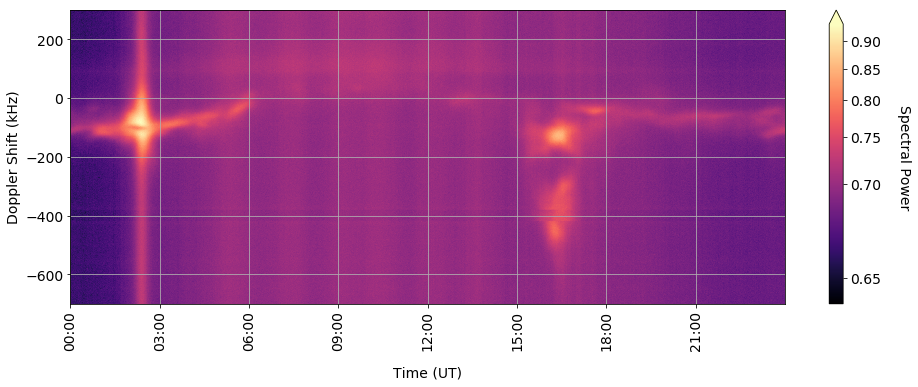

In [40]:
fmt = mdates.DateFormatter('%H:%M') #formatter to show just the hours and minutes

fig, ax = plt.subplots(figsize=(16,6))

pcm = ax.pcolormesh(Xtimes, Yfreqs, sprg.pwr,
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()), #uncomment for log normalized
                    norm=colors.PowerNorm(gamma=1./2.),
                    cmap='magma')

ax.set_xticklabels([fmt(t) for t in ax.get_xticks() ], rotation=90)
ax.set_xlabel('Time (UT)', labelpad=15)
ax.set_ylabel('Doppler Shift (kHz)')
ax.set_ylim(-700,300) #to match the picture
ax.grid()
fig.subplots_adjust(bottom=0.2)
#fig.autofmt_xdate()
cbar=fig.colorbar(pcm, ax=ax, extend='max')
cbar.set_label('Spectral Power', rotation=270, labelpad=30)


#fig.show()


### Compare to the Original
![Terry's Plot](images/LTO-HI-2018-08-30.png)

Future versions of this notebook will improve upon axis labeling, coloring etc. For now this looks like a good first approximation.

## Noise Suppression

The dark areas in the two plots above suggest that most of the power measurements are noise level readings from random sources.
This graph shows frequency counts of power values bucketed into 100 bins.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000269007C4780>]], dtype=object)

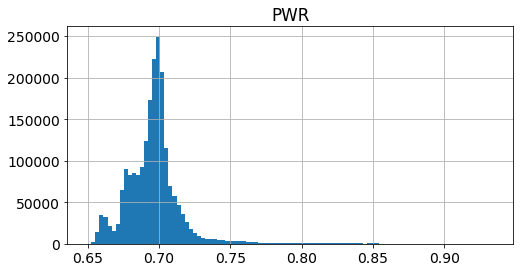

In [58]:
df.hist('PWR', bins=100, figsize=(8,4))

Perhaps there are some interesting frequency bumps out on the right tail of the distrubtion. The plot below shows frequency counts for power values greater than 0.77.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026900C098D0>]], dtype=object)

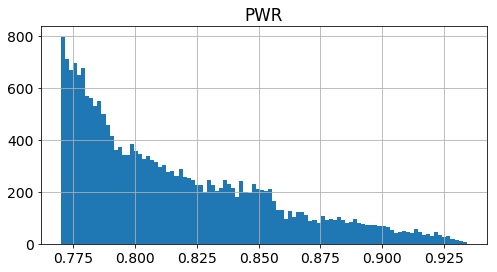

In [59]:
df.query('PWR >= 0.77').hist('PWR', bins=100, figsize=(8,4))

Nope, not much going on in the right tail of the frequency count curve.

In [19]:
#run this code if you have 20 minutes to kill
#df[['PWR']].plot.kde()

## Eliminate the Noise Readings

In [20]:
thresh = 0.7
pwr_nonoise = np.where(pwr > thresh, pwr, 0)

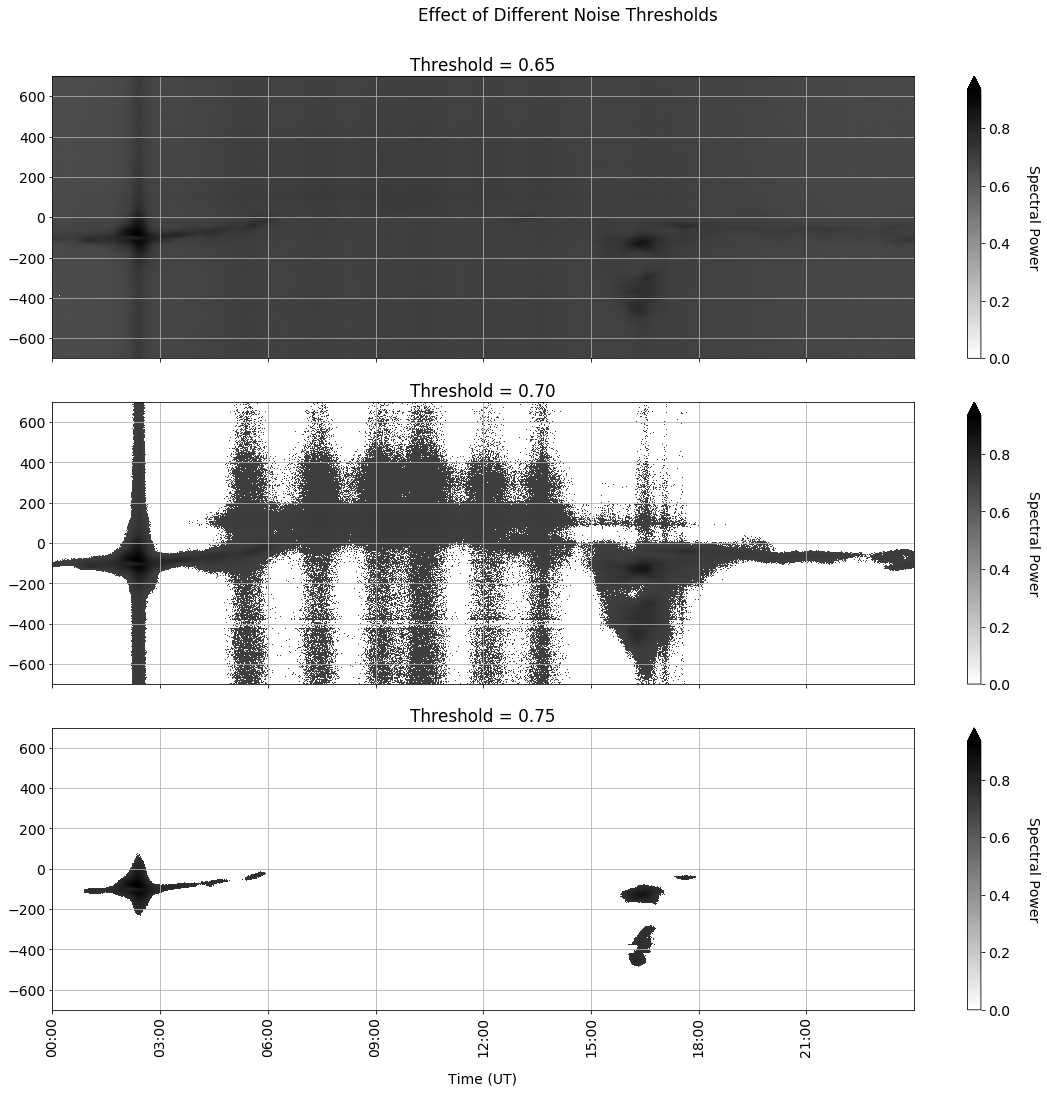

In [41]:
pwr = sprg.pwr

fig = plt.figure(figsize=(16,16))
fig.suptitle('Effect of Different Noise Thresholds')

gs1 = gridspec.GridSpec(3, 1)
ax_list = [fig.add_subplot(ss) for ss in gs1]

ax1 = ax_list[0]
ax2 = ax_list[1]
ax3 = ax_list[2]

pcm = ax1.pcolormesh(Xtimes, Yfreqs, np.where(pwr>=0.65, pwr, 0),
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()),
                   cmap='binary')
ax1.set_title('Threshold = 0.65')
ax1.xaxis.set_ticklabels([]) # suppress x axis tick labels
ax1.grid()
cbar=fig.colorbar(pcm, ax=ax1, extend='max')
cbar.set_label('Spectral Power', rotation=270, labelpad=30)

pcm = ax2.pcolormesh(Xtimes, Yfreqs, np.where(pwr>=0.70, pwr, 0),
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()),
                   cmap='binary')
ax2.set_title('Threshold = 0.70')
ax2.xaxis.set_ticklabels([]) # suppress x axis tick labels
ax2.grid()
cbar=fig.colorbar(pcm, ax=ax2, extend='max')
cbar.set_label('Spectral Power', rotation=270, labelpad=30)

pcm = ax3.pcolormesh(Xtimes, Yfreqs, np.where(pwr>=0.75, pwr, 0),
                   #norm=colors.LogNorm(vmin=pwr.min(), vmax=pwr.max()),
                   cmap='binary')
ax3.set_title('Threshold = 0.75')
ax3.grid()
ax3.set_xticklabels([fmt(t) for t in ax.get_xticks() ], rotation=90)
ax3.set_xlabel('Time (UT)', labelpad=15)
cbar=fig.colorbar(pcm, ax=ax3, extend='max')
cbar.set_label('Spectral Power', rotation=270, labelpad=30)

gs1.tight_layout(fig, rect=[0, 0.03, 1, 0.95])


## Conclusions
Yes, we understand the data well enough to reproduce the spectrograph. On to detecting the HI regions!